# Simulating the motion of a downdraft parcel

Copyright (c) 2021 Thomas Schanzer.  
Distributed under the terms of the BSD 3-Clause License.

In this notebook, we illustrate the use of the `dparcel` package to simulate the motion of descending parcels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from metpy.units import units
from metpy.plots import SkewT

from dparcel.thermo import saturation_specific_humidity
from dparcel.parcel import IdealisedParcel

First create the downdraft parcel associated with an idealised sounding with 50% relative humidity above the boundary layer:

In [2]:
parcel = IdealisedParcel(0.5)

This is what the sounding looks like:

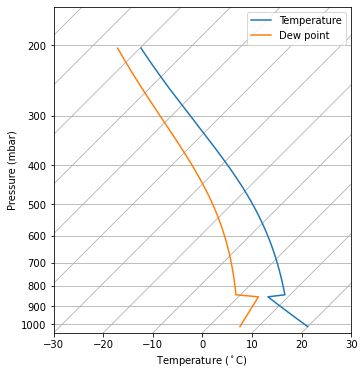

In [3]:
fig = plt.figure(figsize=(6,6))
skew = SkewT(fig, rotation=45)
skew.plot(parcel._pressure_raw, parcel._temperature_raw,
          label='Temperature')
skew.plot(parcel._pressure_raw, parcel._dewpoint_raw, label='Dew point')
lgd = skew.ax.legend()
skew.ax.set_xlim(-30, 30)
skew.ax.set_ylim(top=160)
skew.ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)')
plt.show()

Now set the initial conditions. We use several different entrainment rates, with everything else fixed.

In [4]:
z_initial = 5*units.km
w_initial = 0*units.meter/units.second
p_initial = parcel.pressure(z_initial)
t_initial = parcel.wetbulb_temperature(z_initial)
q_initial = saturation_specific_humidity(p_initial, t_initial)
time = np.arange(0, 10.1, 0.1)*units.minute
rates = np.arange(0, 2.1, 0.1)/units.km
l_initial = 2e-3*units.dimensionless

Using the `parcel.motion` method, simulate the parcel's motion for each set of initial conditions:

In [5]:
%%time
sols = []
for i, rate in enumerate(rates):
    sys.stdout.write('\rCalculation {} of {}    '.format(i+1, rates.size))
    sol = parcel.motion(
        time, z_initial, w_initial, t_initial, q_initial, l_initial, rate,
        kind='reversible')
    sols.append(sol)
sys.stdout.write('\n')

Calculation 21 of 21    
CPU times: user 35.2 s, sys: 250 ms, total: 35.5 s
Wall time: 35.4 s


1

Now plot the results:

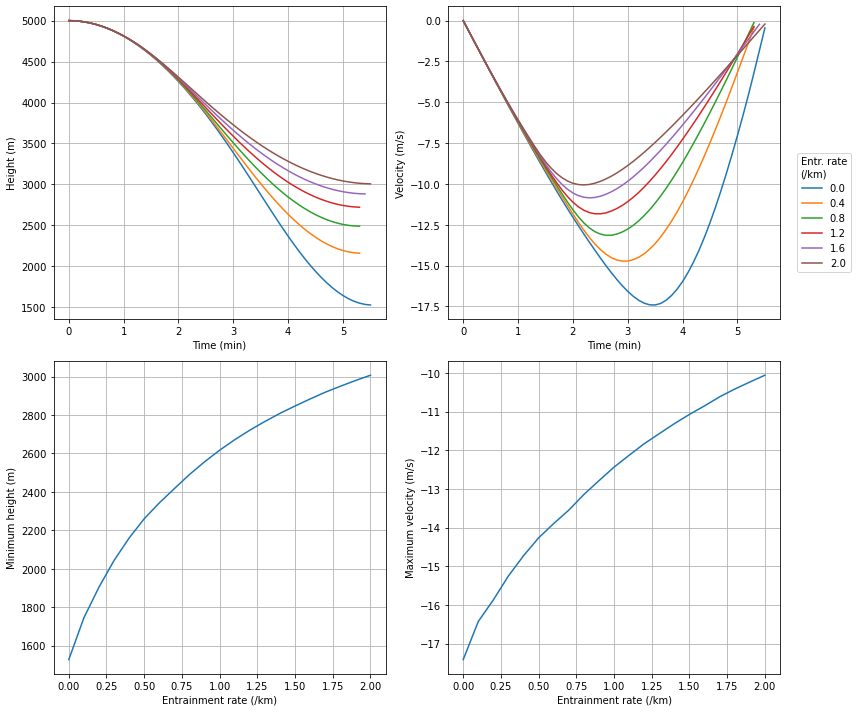

In [6]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(221)
for sol, rate in zip(sols[::4], rates[::4]):
    ax.plot(time, sol.height)
ax.grid()
ax.set(
    xlabel='Time (min)',
    ylabel='Height (m)')

ax = fig.add_subplot(222)
for sol, rate in zip(sols[::4], rates[::4]):
    ax.plot(time, sol.velocity, label='{:.1f}'.format(rate.m))
lgd = ax.legend(loc=[1.05, 0.15])
lgd.set_title('Entr. rate\n(/km)')
ax.grid()
ax.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)')

ax = fig.add_subplot(223)
ax.plot(rates, [sol.min_height.m for sol in sols])
ax.grid()
ax.set(
    xlabel='Entrainment rate (/km)',
    ylabel='Minimum height (m)')

ax = fig.add_subplot(224)
ax.plot(rates, [np.nanmin(sol.velocity.m) for sol in sols])
ax.grid()
ax.set(
    xlabel='Entrainment rate (/km)',
    ylabel='Maximum velocity (m/s)')

fig.tight_layout()
plt.show()

We see that entrainment impedes the parcel's descent; mixing it with the environment causes it to come into equilibrium faster.

These calculations are not restricted to idealised soundings; see the "Supplying your own atmospheric sounding" for instructions to supply your own real sounding data.